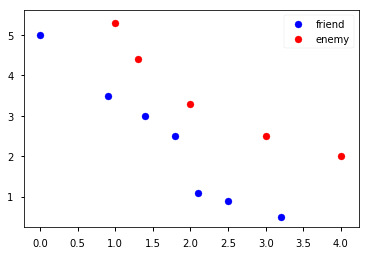

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import scipy.stats as stats
from scipy.special import logsumexp
import scipy

friend_point = np.array([[0.0,5],[0.9,3.5],[1.4,3.0],[1.8,2.5],[2.1,1.1],[2.5,0.9],[3.2,0.5]])
enemy_point = np.array([[1.0,5.3],[1.3,4.4],[2.0,3.3],[3.0,2.5],[4.0,2.0]])

_x = np.linspace(-1,5,100)
_y = np.linspace(0,6,100)

xx,yy = np.meshgrid(_x,_y)

plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


In [2]:
X = np.vstack([friend_point, enemy_point])
Y = np.ones(X.shape[0],dtype=int)
Y[:friend_point.shape[0]] = 0

X,Y

(array([[0. , 5. ],
        [0.9, 3.5],
        [1.4, 3. ],
        [1.8, 2.5],
        [2.1, 1.1],
        [2.5, 0.9],
        [3.2, 0.5],
        [1. , 5.3],
        [1.3, 4.4],
        [2. , 3.3],
        [3. , 2.5],
        [4. , 2. ]]), array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

In [3]:
friend_mu_xy = friend_point.mean(axis=0)
friend_sd_xy = friend_point.std(axis=0)
enemy_mu_xy = enemy_point.mean(axis=0)
enemy_sd_xy = enemy_point.std(axis=0)

mu = np.array([friend_mu_xy,enemy_mu_xy])
sd = np.array([friend_sd_xy,enemy_sd_xy])
logPC = np.log(np.array([np.sum(Y==0)/len(Y),np.sum(Y==1)/len(Y)]))

    

In [4]:
def norm_log_prob(X,mu,sd,drop_constant = False):
    #这里好像弃掉和sigma相关的常数项好像是不对的，等会看看.确实，参见，实际实验也显示这样将得到不一样的结果
    #https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/naive_bayes.py#L425
    
    temp = -(X - mu)**2/(2*sd) 
    if not drop_constant:
        temp = temp - 0.5 * np.log(2.0 * np.pi * sd)
    return temp

def norm_naive_bayes_predict(X,mu,sd,logPC):
    # X: sample_size * features
    # mu: class_size * features
    # sd: class_size * featrues
    # log_PC class_size
    n_class = logPC.shape[0]
    n_feature = X.shape[1]
    n_sample = X.shape[0]
    _X = np.tile(X,[1,n_class]).reshape([n_sample,n_class,n_feature])
    cp = norm_log_prob(_X,mu,sd).sum(axis=2) + logPC  
    log_predict_prob = (cp.T - logsumexp(cp,axis=1)).T
    return log_predict_prob


In [5]:
np.exp(norm_naive_bayes_predict(X,mu,sd,logPC))

array([[0.43142666, 0.56857334],
       [0.58995125, 0.41004875],
       [0.63286367, 0.36713633],
       [0.68727257, 0.31272743],
       [0.88827053, 0.11172947],
       [0.88838863, 0.11161137],
       [0.89157368, 0.10842632],
       [0.31386954, 0.68613046],
       [0.39496821, 0.60503179],
       [0.49925332, 0.50074668],
       [0.51973236, 0.48026764],
       [0.45872438, 0.54127562]])

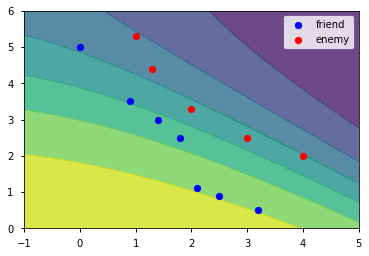

In [6]:
Z = norm_naive_bayes_predict(np.c_[xx.ravel(),yy.ravel()],mu,sd,logPC).reshape(xx.shape+(2,))

cm = plt.cm.RdBu
plt.contourf(xx, yy, np.exp(Z[:,:,0]), alpha=.8)
plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


In [7]:
__x = np.linspace(-5,10,200)
__y = np.linspace(-5,10,200)


In [8]:
class GridSampler2d:
    def __init__(self,prob,x,y):
        # prob: n_sample * 2 -> n_sample
        self.prob = prob
        self.x,self.y = x,y
        self.x_step = x[1] - x[0]
        self.y_step = y[1] - y[0]
        xx, yy = np.meshgrid(x,y)
        self.xx,self.yy = xx,yy
        xy = np.c_[xx.ravel(),yy.ravel()]
        self.xy = xy
        _prob = prob(xy)
        self.grid_prob = _prob / _prob.sum()
    def sample(self, size):
        base = self.xy[np.random.choice(len(self.xy), size, p=self.grid_prob)]
        x_noise = stats.uniform(-self.x_step/2, self.x_step/2).rvs(size)
        y_noise = stats.uniform(-self.y_step/2, self.x_step/2).rvs(size)
        base[:,0] += x_noise
        base[:,1] += y_noise
        return base

In [9]:
def prob(xy, conflict_threshold, distance_threshold,tense = 1.0):
    conflict = np.exp(norm_naive_bayes_predict(xy,mu,sd,logPC)).prod(axis=1)
    distance = scipy.spatial.distance.cdist(xy, X).min(axis=1)
    #p = np.zeros(xy.shape[0])
    #p[(conflict > conflict_threshold) & (distance < distance_threshold)] = 1
    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)
    return p / p.sum()

In [10]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def soft_cut_ge(x,threshold,tense=1.0):
    return sigmoid(tense*(x-threshold))

def soft_cut_le(x,threshold,tense=1.0):
    return sigmoid(tense*(-x+threshold))


In [20]:
_enemy_point = enemy_point

In [21]:
def show_sample(_x,_y, conflict_threshold=0.1,distance_threshold=2.0, tense=1.0, size=10,hist=True, return_sample=False,show=True,enemy=None):
    
    if enemy is not None:
        enemy_point = enemy
    else:
        enemy_point = _enemy_point
    
    
    xx,yy = np.meshgrid(_x,_y)
    xy = np.c_[xx.ravel(),yy.ravel()]
    _prob = lambda xy:prob(xy,conflict_threshold,distance_threshold, tense = tense)
    _prob_xy = _prob(xy)
            
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, _prob_xy.reshape(xx.shape), alpha=.8)
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    
    sampler = GridSampler2d(_prob ,_x,_y)
    sample = sampler.sample(size)
    plt.scatter(sample[:,0],sample[:,1],color='green',label='battle')
    plt.legend()
    if show:
        plt.show()
    
    if hist:
        plt.hist(_prob_xy)
    if return_sample:
        return sample

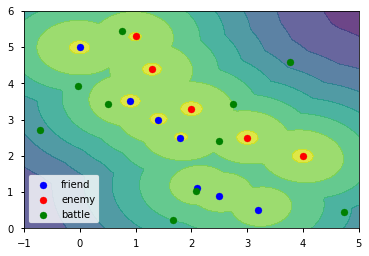

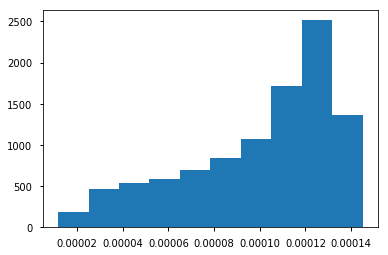

In [22]:
show_sample(_x,_y,conflict_threshold=0.15,distance_threshold=1.5,enemy=enemy_point)

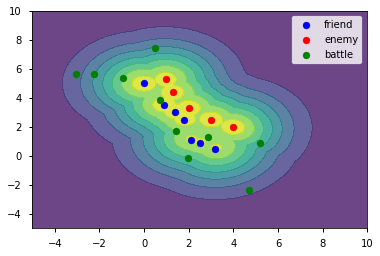

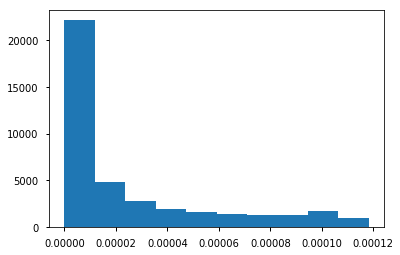

In [24]:
show_sample(__x,__y,conflict_threshold=0.15,distance_threshold=1.5)

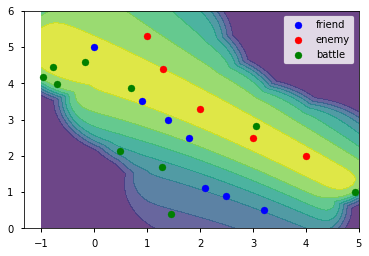

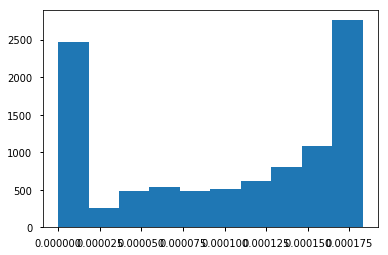

In [25]:
show_sample(_x,_y,conflict_threshold=0.2,distance_threshold=1.5,tense = 10.0)

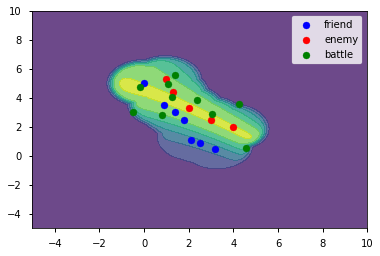

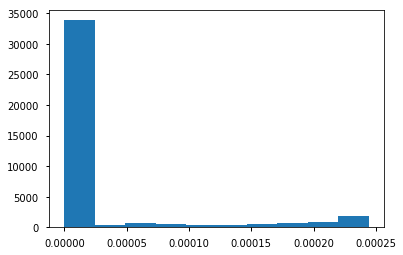

In [26]:
battle_point = show_sample(__x,__y,conflict_threshold=0.2,distance_threshold=1.5,tense = 10.0, return_sample=True)

In [27]:
battle_point

array([[-0.19218743,  4.71590436],
       [ 1.38600962,  5.5512839 ],
       [ 3.05023886,  2.91432179],
       [ 1.07274493,  4.92151802],
       [ 2.35362575,  3.8626928 ],
       [ 1.23971936,  4.04078796],
       [ 0.78757744,  2.81426836],
       [-0.48919788,  3.05258488],
       [ 4.56533233,  0.55658402],
       [ 4.24201312,  3.5746528 ]])

# pytorch实现

下面用pytorch先实现计算原参数本身的梯度，之后的三种贝叶斯算法均需用上这个信息。这个梯度有些相关代码实现在battle_pytorch和pystan_and_pytorch
中已经被实现过了。

In [28]:
import torch
from torch.autograd import Variable

In [29]:
def torch_logsumexp(X,dim=0):
    return torch.log(torch.exp(X).sum(dim=dim))
def torch_tile(X,repeats):
    return X.repeat(*repeats)


def torch_soft_cut_ge(x,threshold,tense=1.0):
    return torch.sigmoid(tense*(x-threshold))

def torch_soft_cut_le(x,threshold,tense=1.0):
    return torch.sigmoid(tense*(-x+threshold))

def torch_transpose(x):
    return x.transpose(0,1)

In [30]:
def torch_norm_log_prob(X,mu,sd):
    #这里好像弃掉和sigma相关的常数项好像是不对的，等会看看.确实，参见，实际实验也显示这样将得到不一样的结果
    #https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/naive_bayes.py#L425
    
    temp = -(X - mu)**2/(2*sd) 
    temp = temp - 0.5 * torch.log(2.0 * np.pi * sd)
    return temp

def torch_norm_naive_bayes_predict(X,mu,sd,logPC):
    # X: sample_size * features
    # mu: class_size * features
    # sd: class_size * featrues
    # log_PC class_size
    n_class = logPC.size()[0]
    n_feature = X.size()[1]
    n_sample = X.size()[0]
    _X = torch_tile(X,[1,n_class]).resize(n_sample,n_class,n_feature)
    cp = torch_norm_log_prob(_X, mu, sd).sum(dim=2) + logPC  
    log_predict_prob = torch_transpose((torch_transpose(cp) - torch_logsumexp(cp,dim=1)))
    return log_predict_prob


In [31]:
def torch_dis(A,B):
    #d = A.repeat(B.size()[0],1).resize(A.size()[0],B.size()[0],2) - B 
    #return (d**2).sum(dim=2)
    d = A.repeat(1,B.size()[0]).resize(A.size()[0]*B.size()[0],2).resize(A.size()[0],B.size()[0],2) - B
    return torch.sqrt((d**2).sum(dim=2)) # 这里和numpy_dis的实现应该差个根号


In [32]:
def Variable_np(array):
    return Variable(torch.from_numpy(array).float())
def Variable_scaler(x):
    return Variable(torch.ones(1)*x)

#friend = Variable_np(friend_point)
#battle = Variable_np(battle_point)
#mu = Variable_np(mu)
#sd = Variable_np(sd)

In [34]:
def model(friend, battle, conflict_threshold = 0.2, distance_threshold = 1.0, tense = 10.0):
    friend_enemy = torch.cat((friend, enemy),0)
    distance = torch_dis(battle, friend_enemy).min(dim=1)[0]
    
    torch_logPC = Variable_np(logPC)
    
    mu = Variable(torch.zeros(2,2)) #目前外层还有个同名的numpy.array mu,sd变量不要搞混了
    sd = Variable(torch.zeros(2,2))
    mu[0,:] = friend.mean(dim=0)
    mu[1,:] = enemy.mean(dim=0)
    sd[0,:] = friend.std(dim=0)
    sd[1,:] = enemy.std(dim=0)
    
    conflict = torch.exp(torch_norm_naive_bayes_predict(battle, mu, sd, torch_logPC)).prod(dim=1)
    
    p = torch_soft_cut_ge(conflict,conflict_threshold, tense = tense) * torch_soft_cut_le(distance, distance_threshold, tense = tense)
    
    target= torch.sum(torch.log(p))
    return target

In [35]:
enemy = Variable(torch.from_numpy(enemy_point).float(),requires_grad=True)

In [43]:
optimizer = torch.optim.SGD([enemy], lr=0.01)

for epoch in range(1000):
    optimizer.zero_grad()
    target = model(Variable_np(friend_point), Variable_np(battle_point), 
                   conflict_threshold = 0.2, distance_threshold = 1.0, tense = 10.0)
    loss = - target # target在这里是似然函数，应该最大化，所以loss应该取反。但在类stan的一些实现中那些梯度是不要取反的，需要注意
    loss.backward()
    optimizer.step()


In [44]:
enemy

Variable containing:
 1.3013  5.0233
-0.3848  2.3820
 2.2478  3.2212
 2.9230  2.2429
 4.0087  2.9512
[torch.FloatTensor of size 5x2]

In [45]:
enemy_point

array([[1. , 5.3],
       [1.3, 4.4],
       [2. , 3.3],
       [3. , 2.5],
       [4. , 2. ]])

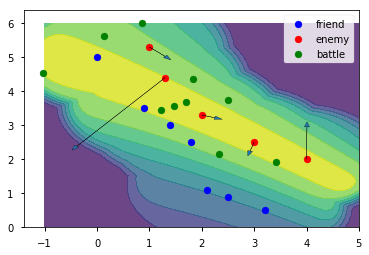

In [46]:
show_sample(_x,_y,conflict_threshold=0.2,distance_threshold=1.5,tense = 10.0,show=False,hist=False)
for i in range(enemy_point.shape[0]):
    s = 0.1
    #plt.arrow(enemy.data[i][0], enemy.data[i][1], s*enemy.grad.data[i][0],s*enemy.grad.data[i][1])
    plt.arrow(enemy_point[i][0], enemy_point[i][1], enemy.data[i][0] - enemy_point[i][0], enemy.data[i][1] - enemy_point[i][1],head_width=0.1)
plt.legend()
plt.show()


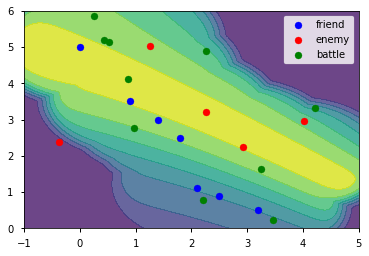

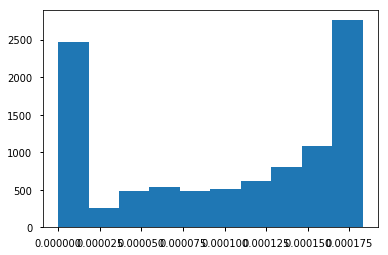

In [40]:
show_sample(_x,_y,conflict_threshold=0.2,distance_threshold=1.5,tense = 10.0,enemy = enemy.data.numpy())

In [41]:
def grad_meanfield(param, q_size = 10, conflict_threshold = 0.2, distance_threshold = 1.0, tense = 10.0):
    '''
    param : n_param * 2 [[p1_mu,p1_std],[p2_mu,p2_std],...]
    '''
    n_param = param.shape[0]
    mu_q_samples_eta = np.random.normal(size=[q_size,n_param])
    mu_q_samples = mu_q_samples_eta * np.exp(param[:,1]) + param[:,0]
    mu_q_mu_grad = np.zeros(n_param)
    mu_q_omega_grad = np.zeros(n_param)
    
    for mu_q_samples_eta,mu_q_sample in zip(mu_q_samples_eta,mu_q_samples):
        mu_q = Variable(torch.from_numpy(mu_q_sample), requires_grad=True)
        # 这里enemy仍然是个全局变量，感觉那么实现不是很吼
        target = model(friend, battle, conflict_threshold = conflict_threshold, distance_threshold = distance_threshold, tense = tense)
        target.backward()
        #loss = -target
        #loss.backward()
        mu_q_mu_grad += mu_q.grad.data.numpy()
        
        #print(target.data[0],mu_q.grad.data.numpy(), mu_q_samples_eta, np.exp(mu_q_omega))
        mu_q_omega_grad += mu_q.grad.data.numpy() * mu_q_samples_eta #*np.exp(mu_q_omega)
        
    mu_q_mu_grad /= q_size
    mu_q_omega_grad /= q_size
    mu_q_omega_grad *= np.exp(mu_q_omega)
    mu_q_omega_grad += 1.0
    return mu_q_mu_grad,mu_q_omega_grad

In [42]:
grad_meanfield(np.random.random(size=enemy_point.shape))

NameError: name 'friend' is not defined